# pybacktest tutorial

This tutorial will give you a quick overview of **pybacktest**'s features. To do so, we will backtest classic MA crossover trading strategy:

* go long when short MA crosses above long MA
* go short when short MA crosses below long MA
* entry rules are also exit rules, thus making strategy reversible

Package is available for download at https://github.com/ematvey/pybacktest

In [1]:
from __future__ import print_function

import pybacktest  # obviously, you should install pybacktest before importing it
import pandas as pd

**pybacktest** expects bars to be in `pandas.DataFrame` indexed by datetimestamps, with columns named `O`, `H`, `L`, `C`. Actually, in this version it would only check `O`, and only if trade prices are not explicitly specified.

Lets load data from yahoo using helper.

In [2]:
ohlc = pybacktest.load_from_yahoo('SPY')
ohlc.tail()

,O,H,L,C,V
Date,,,,,
2016-10-05,215.410004,216.130005,215.330002,215.630005,72816000
2016-10-06,215.369995,216.039993,214.740005,215.779999,62927400
2016-10-07,216.100006,216.300003,214.190002,215.039993,89788300
2016-10-10,216.160004,216.699997,215.990005,216.160004,51855000
2016-10-11,215.660004,215.740005,212.580002,213.429993,127220400


Now time to define strategy. To do so, all we need to do is to create binary `Series` with signals, and, optionally, trade price `Series` with float elements.

Could this be any simpler?

In [3]:
short_ma = 50
long_ma = 200

ms = ohlc.C.rolling(short_ma).mean()
ml = ohlc.C.rolling(long_ma).mean()
    
buy = cover = (ms > ml) & (ms.shift() < ml.shift())  # ma cross up
sell = short = (ms < ml) & (ms.shift() > ml.shift())  # ma cross down

print('>  Short MA\n%s\n' % ms.tail())
print('>  Long MA\n%s\n' % ml.tail())
print('>  Buy/Cover signals\n%s\n' % buy.tail())
print('>  Short/Sell signals\n%s\n' % sell.tail())

>  Short MA
Date
2016-10-05    215.970410
2016-10-06    215.977374
2016-10-07    215.964564
2016-10-10    215.967189
2016-10-11    215.918796
Name: C, dtype: float64

>  Long MA
Date
2016-10-05    204.611649
2016-10-06    204.697578
2016-10-07    204.770798
2016-10-10    204.837210
2016-10-11    204.891645
Name: C, dtype: float64

>  Buy/Cover signals
Date
2016-10-05    False
2016-10-06    False
2016-10-07    False
2016-10-10    False
2016-10-11    False
Name: C, dtype: bool

>  Short/Sell signals
Date
2016-10-05    False
2016-10-06    False
2016-10-07    False
2016-10-10    False
2016-10-11    False
Name: C, dtype: bool



Time to run backtest. `Backtest` will try to extract signals and prices and bars from whatever dict-like object you passed as first argument. Could be dict, could be pandas.DataFrame or anything.

To make thing easier, pass local namespace (extracted py calling `locals()`), that contains every variable you created up to this point.

In [4]:
bt = pybacktest.Backtest(locals(), 'ma_cross')

`Backtest` runs lazily, i.e. it calculates anything only when you call properties from it. There properties: 

In [5]:
print(list(filter(lambda x: not x.startswith('_'), dir(bt))))
print('\n>  bt.signals\n%s' % bt.signals.tail())
print('\n>  bt.trades\n%s' % bt.trades.tail())
print('\n>  bt.positions\n%s' % bt.positions.tail())
print('\n>  bt.equity\n%s' % bt.equity.tail())
print('\n>  bt.trade_price\n%s' % bt.trade_price.tail())

['dataobj', 'default_price', 'eqplot', 'equity', 'name', 'ohlc', 'plot_equity', 'plot_trades', 'positions', 'prices', 'report', 'run_time', 'signals', 'sigplot', 'stats', 'summary', 'trade_price', 'trades', 'trdplot']

>  bt.signals
              Buy  Cover   Sell  Short
Date                                  
2016-10-05  False  False  False  False
2016-10-06  False  False  False  False
2016-10-07  False  False  False  False
2016-10-10  False  False  False  False
2016-10-11  False  False  False  False

>  bt.trades
            pos       price  vol
Date                            
2012-01-24  1.0  118.699844  2.0
2015-09-04 -1.0  187.808625 -2.0
2015-12-10  1.0  201.090047  2.0
2016-01-19 -1.0  187.062636 -2.0
2016-04-21  1.0  207.982340  2.0

>  bt.positions
Date
2012-01-23    1.0
2015-09-03   -1.0
2015-12-09    1.0
2016-01-15   -1.0
2016-04-20    1.0
dtype: float64

>  bt.equity
Date
2012-01-24   -14.184135
2015-09-04    69.108781
2015-12-10   -13.281422
2016-01-19   -14.027411
2016-04

Some of popular performance statistics could be requested by calling `summary` method of `Backtest`.

In [6]:
bt.summary()

----------------------------------------------
|  Backtest(ma_cross, 2016-12-10 19:14 MSK)  |
('----------------------------------------------', '\n')
backtest:
  days: 7902
  from: '1994-09-02 00:00:00'
  to: '2016-04-21 00:00:00'
  trades: 21
performance:
  PF: 2.7793
  RF: 3.4981
  averages:
    gain: 23.9572
    loss: -9.4819
    trade: 8.0338
  payoff: 2.5266
  profit: 168.7103
  winrate: 0.5238
risk/return profile:
  MPI: 0.5665
  UPI: 0.5665
  WCDD (monte-carlo 0.99 quantile): 69.1196
  maxdd: 48.2285
  sharpe: 0.3593
  sortino: 1.1669

----------------------------------------------


Now lets look at equity curve.

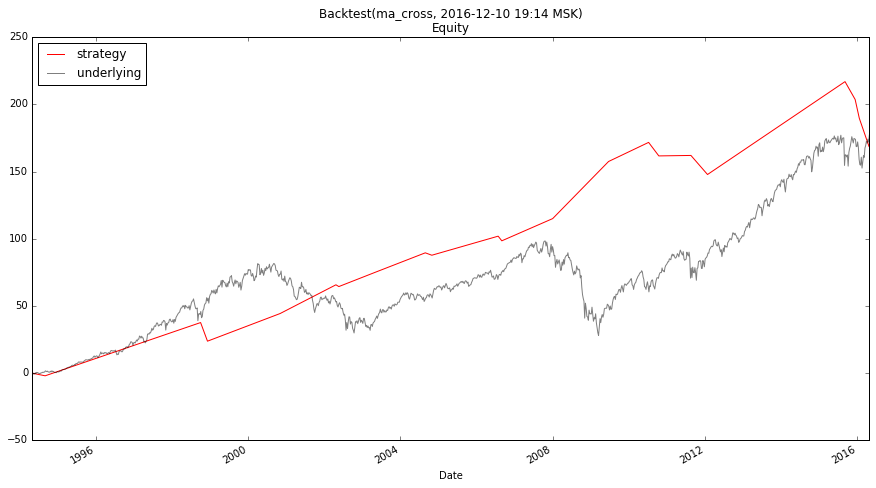

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

bt.plot_equity()

But what if you want to see what exactly was going on during backtest run? Well, `Backtest` can plot trades as they happened for you. Legend is hidden by default to save space.

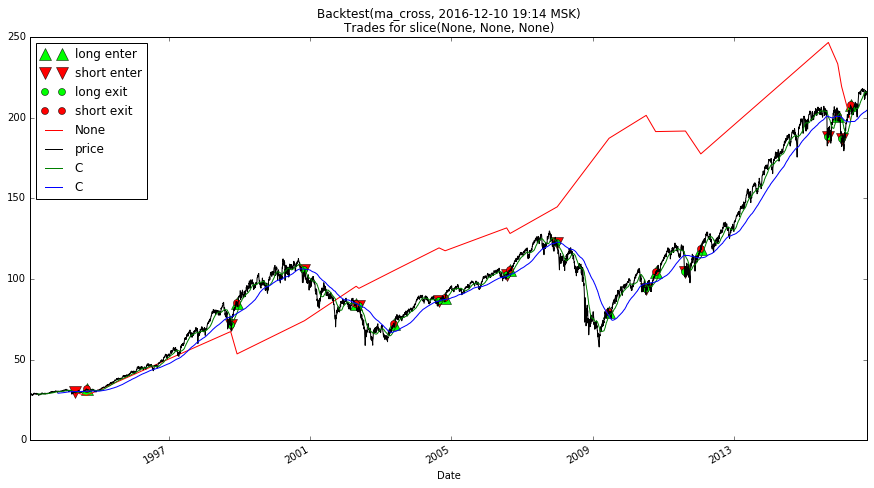

In [8]:
bt.plot_trades()
ohlc.C.rolling(short_ma).mean().plot(c='green')
ohlc.C.rolling(long_ma).mean().plot(c='blue')
plt.legend(loc='upper left')
pass

Can you see anything there? I can't. That's why we have special a very special `trdplot` property, which allowes you specify what period do you want to plot using standard `pandas` indexing mechanisms. Same trick could be done with equity curve using `eqplot` property.

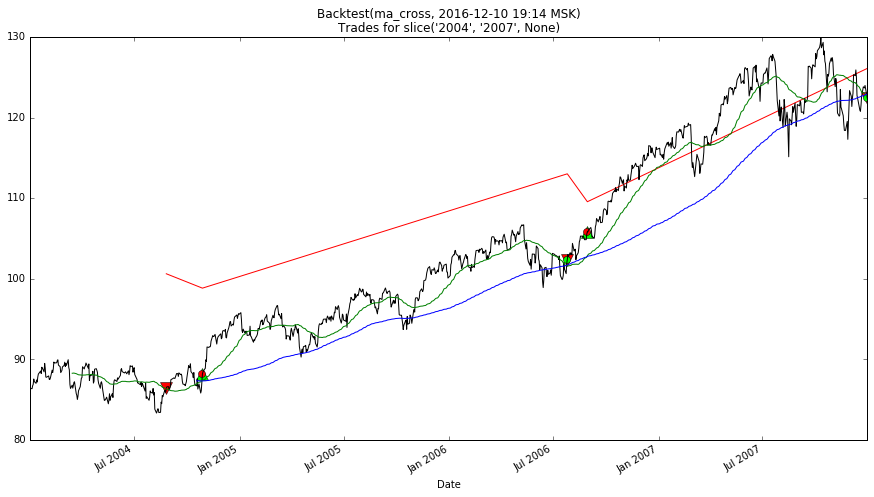

In [9]:
bt.trdplot['2004':'2007']
ohlc.C['2004':'2007'].rolling(short_ma).mean().plot(c='green')
ohlc.C['2004':'2007'].rolling(long_ma).mean().plot(c='blue')
pass

That's the most of it.